In [1]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

Using TensorFlow backend.


In [2]:
#converting the text files to pandas dataframe
#pd로 text파일 불러온다 sep은 tap간격으로 불러오고 열마다 이름 설정
image_tokens=pd.read_csv("Data/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("Data/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("Data/Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("Data/Flickr_8k.devImages.txt",names=["img_id"])

In [3]:
#just checking the number of images in the dataset
#데이터 갯수 확인
l=os.listdir("Data/Flickr8k_Dataset")
print(len(l))

8091


"A man in street racer armor be examine the tire of another racer 's motorbike ."

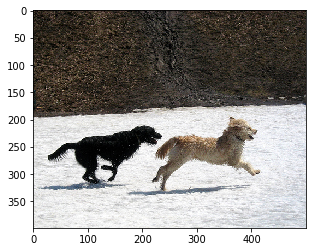

In [4]:
#visualising one of the train images
#트레인 이미지에 [0]에 저장되어 있는 이미지 보기
img=cv2.imread("Data/Flickr8k_Dataset"+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
image_tokens.img_caption[0]

In [5]:
#removing the #0,#1,#2,#3,#5 from the image ids
#맨 끝 두 글자 삭제함->#N
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [6]:
#공백과 \n을 strip으로 제거 후 양쪽에 start와 end를 붙인다.
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")
image_tokens.img_caption[1]

'<start> Two racer drive a white bike down a road . <end>'

In [7]:
#head of the image_tokens dataframe
image_tokens.head()

,img_id,img_caption
0,1305564994_00513f9a5b.jpg,<start> A man in street racer armor be examine...
1,1305564994_00513f9a5b.jpg,<start> Two racer drive a white bike down a ro...
2,1305564994_00513f9a5b.jpg,<start> Two motorist be ride along on their ve...
3,1305564994_00513f9a5b.jpg,<start> Two person be in a small race car driv...
4,1305564994_00513f9a5b.jpg,<start> Two person in race uniform in a street...


In [8]:
#head of the train_image_names dataframe
train_image_names.head()

,img_id
0,2513260012_03d33305cf.jpg
1,2903617548_d3e38d7f88.jpg
2,3338291921_fe7ae0c8f8.jpg
3,488416045_1c6d903fe0.jpg
4,2644326817_8f45080b87.jpg


In [9]:
#creating train dictionary having key as the image id and value as a list of its captions
#이미지 id로 하여금 캡션과 맞춘다?
train_captions={}
for i in tqdm(range(len(train_image_names))):
    l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
    train_captions[train_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:42<00:00, 142.48it/s]


In [10]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
    l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
    test_captions[test_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.93it/s]


In [11]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
    l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
    validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.43it/s]


In [12]:
from keras import models
from keras.applications import VGG16

model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
#model=VGG16(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
#model=models.Model(inputs=model.input,outputs=model.layers[-3].output)
model.summary()

W1013 13:38:10.759486  8504 deprecation_wrapper.py:119] From c:\users\admin\.conda\envs\josy0319\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1013 13:38:10.803186  8504 deprecation_wrapper.py:119] From c:\users\admin\.conda\envs\josy0319\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1013 13:38:10.826602  8504 deprecation_wrapper.py:119] From c:\users\admin\.conda\envs\josy0319\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1013 13:38:10.869268  8504 deprecation_wrapper.py:119] From c:\users\admin\.conda\envs\josy0319\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_7 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________

In [13]:
#extracting image encodings(features) from resnet50 and forming dict train_features
path="Data/Flickr8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
    img_path=path+image_name
    img=image.load_img(img_path,target_size=(224,224))
    x = image.img_to_array(img)
    #이미지를 배열로 바꿈
    x = np.expand_dims(x, axis=0)
    #차원을 하나 늘린다 (1,224,224)
    x = preprocess_input(x)
    features = model.predict(x)
    #지정한 모델을 통해 피쳐맵 추출
    train_features[image_name]=features.squeeze()
    #차원중 사이즈가 1인것을 제거

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [31:05<00:00,  3.11it/s]


In [14]:
with open( "train_encoded_images_lite.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )
train_features["2513260012_03d33305cf.jpg"].shape

(2048,)

In [15]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="Data/Flickr8k_Dataset/"
test_features={}
c=0
for image_name in tqdm(test_captions):
    img_path=path+image_name
    img=image.load_img(img_path,target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    test_features[image_name]=features.squeeze()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:17<00:00,  3.22it/s]


In [16]:
with open( "test_encoded_images_lite.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [17]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="Data/Flickr8k_Dataset/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
    img_path=path+image_name
    img=image.load_img(img_path,target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    validation_features[image_name]=features.squeeze()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:04<00:00,  3.43it/s]


In [18]:
with open( "validation_encoded_images_lite.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

In [19]:
#올 캡션인데 트레인 캡션만 저장했음
all_captions=[]
for img_id in tqdm(train_captions):
    for captions in train_captions[img_id]:
        all_captions.append(captions)
for img_id in tqdm(validation_captions):
    for captions in validation_captions[img_id]:
        all_captions.append(captions)   
for img_id in tqdm(test_captions):
    for captions in test_captions[img_id]:
        all_captions.append(captions)

#all_captions는 한 문장씩
all_words=" ".join(all_captions)

print(all_words[0])
print(all_words[1])
print(all_captions[0])

print(len(all_words))
#글자의 수 출력
unique_words=list(set(all_words.strip().split(" ")))

print(unique_words[0])
print(unique_words[1])
#unique_words는 단어를 만들고 " "기준으로 나눈다

print(len(unique_words))
#단어의 수 출력

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 334207.49it/s]


<
s
<start> A black dog be run after a white dog in the snow . <end>
2659273
beauty
hook
7292


In [20]:
vocab_size=len(unique_words)+1
#총 단어의 수 +1
max_length=40

In [21]:
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"
#단어를 인덱스로 / 인덱스를 단어로
print(unique_words[3])
print(indices_to_words[0])
print(indices_to_words[1])
print(words_to_indices["Unk"])
print(words_to_indices["fries"])

shark
Unk
beauty
0
2263


In [22]:
train_encoded_captions={}
for img_id in tqdm(train_captions):
    train_encoded_captions[img_id]=[]
    for i in range(5):
        train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])
print(train_encoded_captions["2513260012_03d33305cf.jpg"])
print(train_captions["2513260012_03d33305cf.jpg"])
#워드를 인덱스로 바꿔서 저장

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 39812.98it/s]


[[4712, 1752, 6812, 394, 3699, 4477, 3460, 1013, 2486, 394, 1541, 4649, 6147, 4393, 2747], [4712, 3371, 394, 1490, 5449, 394, 4555, 6147, 2747], [4712, 2507, 394, 1490, 4189, 4858, 900, 4649, 5328, 6328, 4393, 2747], [4712, 2507, 394, 4027, 2105, 1541, 4649, 6147, 4393, 2747], [4712, 2507, 394, 4477, 4555, 1013, 1087, 1239, 6395, 1788, 454, 4393, 2747]]
['<start> A black dog be run after a white dog in the snow . <end>', '<start> Black dog chase brown dog through snow <end>', '<start> Two dog chase each other across the snowy ground . <end>', '<start> Two dog play together in the snow . <end>', '<start> Two dog run through a low lie body of water . <end>']


In [23]:
validation_encoded_captions={}
for img_id in tqdm(validation_captions):
    validation_encoded_captions[img_id]=[]
    for i in range(5):
        validation_encoded_captions[img_id].append([words_to_indices[s] for s in validation_captions[img_id][i].split(" ")])

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 42388.12it/s]


In [24]:
for img_id in tqdm(train_encoded_captions):
    print(train_encoded_captions[img_id])
    break

  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]

[[4712, 1752, 6812, 394, 3699, 4477, 3460, 1013, 2486, 394, 1541, 4649, 6147, 4393, 2747], [4712, 3371, 394, 1490, 5449, 394, 4555, 6147, 2747], [4712, 2507, 394, 1490, 4189, 4858, 900, 4649, 5328, 6328, 4393, 2747], [4712, 2507, 394, 4027, 2105, 1541, 4649, 6147, 4393, 2747], [4712, 2507, 394, 4477, 4555, 1013, 1087, 1239, 6395, 1788, 454, 4393, 2747]]


In [25]:
for img_id in tqdm(train_encoded_captions):
    train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')
print(train_encoded_captions["2513260012_03d33305cf.jpg"])
#앞쪽으로 0패딩한다

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 15115.72it/s]


[[4712 1752 6812  394 3699 4477 3460 1013 2486  394 1541 4649 6147 4393
  2747    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4712 3371  394 1490 5449  394 4555 6147 2747    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4712 2507  394 1490 4189 4858  900 4649 5328 6328 4393 2747    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4712 2507  394 4027 2105 1541 4649 6147 4393 2747    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4712 2507  394 4477 4555 1013 1087 1239 6395 1788  454 4393 2747    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [26]:
for img_id in tqdm(validation_encoded_captions):
     validation_encoded_captions[img_id]=pad_sequences(validation_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 12765.64it/s]


In [27]:
for img_id in tqdm(train_encoded_captions):
    print(train_encoded_captions[img_id])
    break

  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]

[[4712 1752 6812  394 3699 4477 3460 1013 2486  394 1541 4649 6147 4393
  2747    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4712 3371  394 1490 5449  394 4555 6147 2747    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4712 2507  394 1490 4189 4858  900 4649 5328 6328 4393 2747    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4712 2507  394 4027 2105 1541 4649 6147 4393 2747    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4712 2507  394 4477 4555 1013 1087 1239 6395 1788  454 4393 2747    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [28]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
    print(indices_to_words[x])
#영패딩한건 Unk표시 후 단어들 출력

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [29]:
print(train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist())
curr_sequence=train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()
next_word=train_encoded_captions[img_id][0][1]
curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
one_hot_next_word=to_categorical([next_word],vocab_size)[0]
print(curr_sequence)
print(one_hot_next_word)
print(next_word)

[4712]
[4712    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[0. 0. 0. ... 0. 0. 0.]
1752


In [30]:
from tqdm import tqdm_notebook
def train_data_generator(train_encoded_captions,train_features,num_of_photos):
    #train_encoded_caption은 img_id와 인덱스로 변환한 워드의 조합
    X1, X2, Y = list(), list(), list()
    max_length=40
    n=0
    for img_id in tqdm_notebook(train_encoded_captions):
        n+=1
        for i in range(5):
            for j in range(1,40):
                curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
                #현재 캡션의 첫번째 단어의 인덱스를 저장
                next_word=train_encoded_captions[img_id][i][j]
                #그 다음 단어의 인덱스를 저장
                curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
                #curr_sequence의 나머지를 0패딩함
                one_hot_next_word=to_categorical([next_word],vocab_size)[0]
                #next_word를 원 핫인코딩함
                X1.append(train_features[img_id])
                X2.append(curr_sequence)
                Y.append(one_hot_next_word)
        if(n==num_of_photos):
            yield [[array(X1), array(X2)], array(Y)]
            X1, X2, Y = list(), list(), list()
            n=0
            #총 5개의 캡션이니까 5번 돌려서 저장하고 리턴한다 다시 0으로 초기화

In [31]:
def validation_data_generator(validation_encoded_captions,validation_features,num_of_photos):
    #train_encoded_caption은 img_id와 인덱스로 변환한 워드의 조합
    X1, X2, Y = list(), list(), list()
    max_length=40
    n=0
    for img_id in tqdm_notebook(validation_encoded_captions):
        n+=1
        for i in range(5):
            for j in range(1,40):
                curr_sequence=validation_encoded_captions[img_id][i][0:j].tolist()
                #현재 캡션의 첫번째 단어의 인덱스를 저장
                next_word=validation_encoded_captions[img_id][i][j]
                #그 다음 단어의 인덱스를 저장
                curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
                #curr_sequence의 나머지를 0패딩함
                one_hot_next_word=to_categorical([next_word],vocab_size)[0]
                #next_word를 원 핫인코딩함
                X1.append(validation_features[img_id])
                X2.append(curr_sequence)
                Y.append(one_hot_next_word)
        if(n==num_of_photos):
            yield [[array(X1), array(X2)], array(Y)]
            X1, X2, Y = list(), list(), list()
            n=0
            #총 5개의 캡션이니까 5번 돌려서 저장하고 리턴한다 다시 0으로 초기화

In [32]:
#model :)
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.recurrent import LSTM,GRU
from keras.layers.merge import add
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional, TimeDistributed, Permute, Lambda, RepeatVector, Reshape



In [33]:
for i in train_features:
    print(train_features[i].shape)
    break

(2048,)


In [34]:
from keras import backend as K, initializers, regularizers, constraints
from keras.engine.topology import Layer


def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0],input_shape[-1]

In [35]:
print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join('./glove-6b/', 'glove.6B.100d.txt'),encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [36]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
max_words = len(unique_words)+1
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(unique_words)
sequences = tokenizer.texts_to_sequences(unique_words)
word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=40)

print('데이터 텐서의 크기:', data.shape)

embedding_matrix = np.zeros((max_words, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됩니다.
            embedding_matrix[i] = embedding_vector
print(vocab_size)

6357개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (7292, 40)
7293


In [1]:
#lstm 모델 - 완성

input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()


#lstm 모델(attention) - 완성
'''
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
print(input_2)
embedding_1=Embedding(vocab_size,256)(input_2)
print(embedding_1)
embedding_1=Attention()(embedding_1)
print(embedding_1)
embedding_1=RepeatVector(40)(embedding_1)
#embedding_1=TimeDistributed(Dropout(0.2))(embedding_1)
#embedding_1=Reshape((40,256))(embedding_1)
print(embedding_1)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256,return_sequences=False)(dropout_2)
#print(lstm_1)
#lstm_1=Attention()(lstm_1)
#print(lstm_1)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)
print(dense_3)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()
'''

#lstm 모델(attention) - 완성
'''
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256,return_sequences=True)(dropout_2)
lstm_1=Attention()(lstm_1)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)
print(dense_3)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()
'''

#Bi-lstm 모델 - 완성
'''
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=Bidirectional(LSTM(128,return_sequences=False),merge_mode='concat')(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)
print(dense_3)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()
'''

#Bi-lstm 모델(attention) - 완성
'''
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=Bidirectional(LSTM(128,return_sequences=True),merge_mode='concat')(dropout_2)
lstm_1=Attention()(lstm_1)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)
print(dense_3)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()
'''


NameError: name 'Input' is not defined

In [114]:
len(train_encoded_captions)

6000

In [115]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
epochs=1
batch_size=5
train_iteration=len(train_encoded_captions)//batch_size
validation_iteration=len(validation_encoded_captions)//batch_size

for i in range(epochs):
    train_generator=train_data_generator(train_encoded_captions,train_features,batch_size)
    validation_generator=validation_data_generator(validation_encoded_captions,validation_features,batch_size)
    history = model.fit_generator(train_generator,epochs=1,steps_per_epoch=train_iteration,validation_data=validation_generator,validation_steps=validation_iteration,verbose=1,initial_epoch=0)

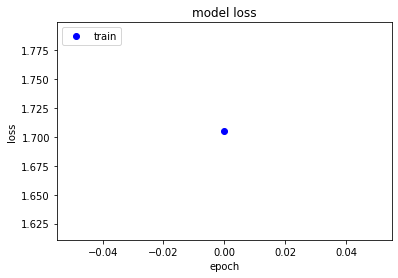

<Figure size 432x288 with 0 Axes>

In [43]:
plt.plot(history.history['loss'],'bo')
#plt.plot(history.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss.png')

In [44]:
test_features

{'3385593926_d3e9c21170.jpg': array([0.2823609 , 0.31681862, 0.04513445, ..., 0.74424076, 0.29651454,
        0.920625  ], dtype=float32),
 '2677656448_6b7e7702af.jpg': array([0.23351432, 0.05175799, 0.6238553 , ..., 0.00523912, 0.26226747,
        0.08674015], dtype=float32),
 '311146855_0b65fdb169.jpg': array([0.00912255, 0.07216533, 0.1220391 , ..., 0.02202931, 1.131913  ,
        0.03853815], dtype=float32),
 '1258913059_07c613f7ff.jpg': array([0.02427802, 1.2347151 , 0.07595009, ..., 0.08897495, 0.09812588,
        1.9384055 ], dtype=float32),
 '241347760_d44c8d3a01.jpg': array([0.0505117 , 6.3199897 , 0.3120082 , ..., 0.05379438, 0.01552999,
        0.02812625], dtype=float32),
 '2654514044_a70a6e2c21.jpg': array([1.7662996 , 0.03384979, 0.10334545, ..., 0.00532009, 0.6680156 ,
        0.39294165], dtype=float32),
 '2339106348_2df90aa6a9.jpg': array([0.06683154, 1.0869427 , 0.07896088, ..., 0.01411188, 0.1311434 ,
        0.09507965], dtype=float32),
 '256085101_2c2617c5d0.jpg': 

In [45]:

def greedy_search(photo):
    photo=photo.reshape(1,2048)
    in_text='<start>'
    for i in range(max_length):
        sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        y_pred = model.predict([photo,sequence],verbose=0)
        y_pred = np.argmax(y_pred[0])
        word = indices_to_words[y_pred]
        in_text += ' ' + word
        if word == '<end>':
            break
    final = in_text.split()
    final = final[1:-1]
    #final = " ".join(final)
    return final


'\ndef greedy_search(photo):\n    photo=photo.reshape(1,2048)\n    in_text=\'<start>\'\n    for i in range(max_length):\n        sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]\n        sequence = pad_sequences([sequence], maxlen=max_length, padding=\'post\')\n        y_pred = model.predict([photo,sequence],verbose=0)\n        y_pred = np.argmax(y_pred[0])\n        word = indices_to_words[y_pred]\n        in_text += \' \' + word\n        if word == \'<end>\':\n            break\n    final = in_text.split()\n    final = final[1:-1]\n    #final = " ".join(final)\n    return final\n'

In [48]:
def beam_search(photo,k):
    photo=photo.reshape(1,2048)
    in_text='<start>'
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    predicted=[]
    y_pred=y_pred.reshape(-1)
    for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
    predicted=sorted(predicted,key=lambda x:x[1])[::-1]
    b_search=[]
    for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search.append((in_text +' ' + word,predicted[i][1]))
    
    for idx in range(max_length):
        b_search_square=[]
        for text in b_search:
            if text[0].split(" ")[-1]=="<end>":
                break
            sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
            sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
            y_pred = model.predict([photo,sequence],verbose=0)
            predicted=[]
            y_pred=y_pred.reshape(-1)
            for i in range(y_pred.shape[0]):
                predicted.append((i,y_pred[i]))
            predicted=sorted(predicted,key=lambda x:x[1])[::-1]
            for i in range(k):
                word = indices_to_words[predicted[i][0]]
                b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
        if(len(b_search_square)>0):
            b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
    final=b_search[0][0].split()
    final = final[1:-1]
    #final=" ".join(final)
    return final

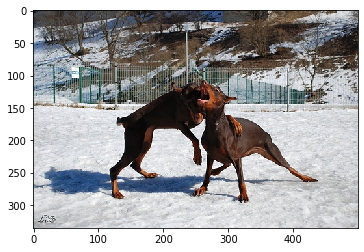

c:\users\admin\.conda\envs\josy0319\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\users\admin\.conda\envs\josy0319\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A dog be be be be be be be be be be be be be be be be be be be in a snow .
bleu score:  5.609571844608773e-155


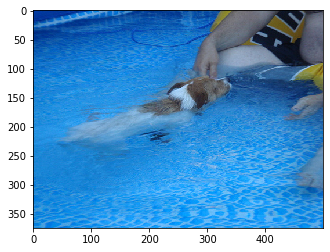

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A boy be be be be be be be be be be be be be be be be be be be in a water .
bleu score:  2.0973052682696393e-78


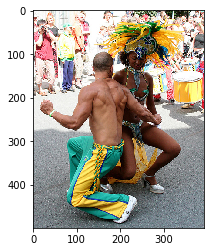

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A boy in a shirt be be be be be be be be be be in a red red shirt in a red red shirt .
bleu score:  4.623615267576204e-155


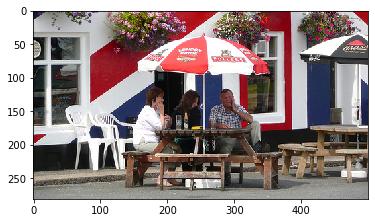

c:\users\admin\.conda\envs\josy0319\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man be be be be be be be be be be be be be be be be be be be in a red red a red red a red a a a a a a a a a
bleu score:  1.1409851298103347e-231


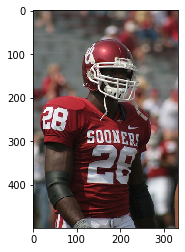

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player be player .
bleu score:  8.067741778751319e-155


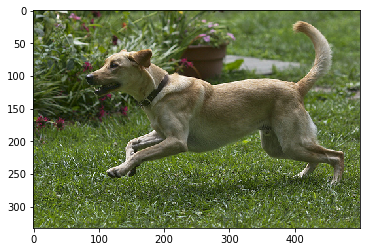

Referance Captions: 
A brown dog run
A brown dog run over grass .
A brown dog with its front paw off the ground on a grassy surface near red and purple flower .
A dog run across a grassy lawn near some flower .
A yellow dog be play in a grassy area near flower .
Predicted Caption: 
A dog be run in a field .
bleu score:  1.1672934071334108e-154


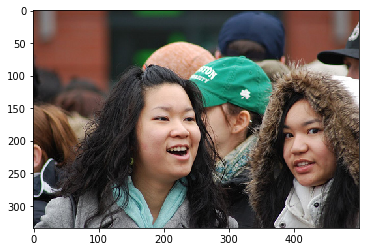

Referance Captions: 
A girl with dark brown hair and eye in a blue scarf be stand next to a girl in a fur edge coat .
an Asian boy and an Asian girl be smile in a crowd of person .
Girl be in a crowd .
Two dark haired girl be in a crowd .
Two girl be look past each other in different direction while stand in a crowd .
Predicted Caption: 
A woman be be be be be be be be be be be be be be in a camera .
bleu score:  2.388207634960466e-78


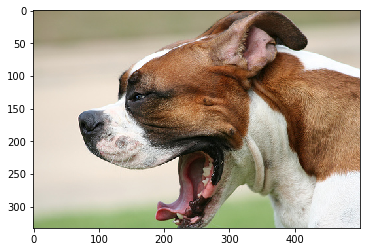

Referance Captions: 
A dog with its mouth open .
Brown and white dog yawn .
Closeup of dog in profile with mouth open .
Dog yawn
A dog 's mouth be open like he be yawn .
Predicted Caption: 
A dog be be be be be be be be be be be be be be be be be be be be with a mouth .
bleu score:  4.805276545626372e-155


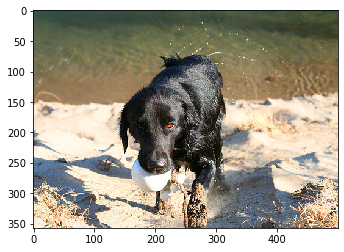

Referance Captions: 
A black dog emerge from the water onto the sand , hold a white object in its mouth .
A black dog emerge from the water with a white ball in its mouth .
A black dog on a beach carry a ball in its mouth .
a black dog walk out of the water with a white ball in his mouth .
Black dog jump out of the water with something in its mouth .
Predicted Caption: 
A black dog be run in the snow .
bleu score:  3.0761252566884164e-78


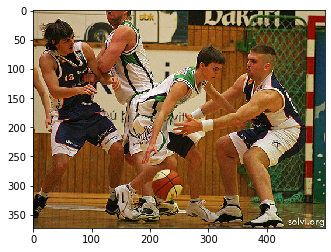

Referance Captions: 
A player from white and green highschool team dribble down court defend by a player from the other team .
Four basketball player in action .
Four man play basketball , two from each team .
Two boy in green and white uniform play basketball with two boy in blue and white uniform .
Young man play basketball in a competition .
Predicted Caption: 
A man be player in a ball .
bleu score:  1.0148936155293581e-154


In [140]:

i=0
for 
in test_features:
    i+=1
    img=cv2.imread("Data/Flickr8k_Dataset"+ "/" + img_id)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    photo=test_features[img_id]
    plt.show()
    reference=[]
    for caps in test_captions[img_id]:
        list_caps=caps.split(" ")
        list_caps=list_caps[1:-1]    
        reference.append(list_caps)
    candidate=greedy_search(photo)
    score = sentence_bleu(reference, candidate)
    print("Referance Captions: ")
    for cap in reference:
        print(" ".join(cap))
    print("Predicted Caption: ")
    print(" ".join(candidate))
    print("bleu score: ",score)
    if(i==10):
        break


In [2]:
#from pycocoevalcap.bleu.bleu import Bleu

i=0
for img_id in test_features:
    i+=1
    img=cv2.imread("Data/Flickr8k_Dataset"+ "/" + img_id)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    photo=test_features[img_id]
    plt.show()
    reference=[]
    for caps in test_captions[img_id]:
        list_caps=caps.split(" ")
        list_caps=list_caps[1:-1]
        reference.append(list_caps)
    candidate=beam_search(photo,3)
    score = sentence_bleu(reference, candidate)
'''    
    scorer = Bleu(n=4)
    score, scores = scorer.compute_score(reference, candidate)
    print('belu = %s' % score)
'''

    print("Referance Captions: ")
    for cap in reference:
        print(" ".join(cap))
    print("Predicted Caption: ")
    print(" ".join(candidate))
    print("bleu score: ",score)
    if(i==10):
        break


IndentationError: unexpected indent (<ipython-input-2-34bfa4ac194f>, line 23)

In [141]:

i=0
tot_score=0
for img_id in tqdm(test_features):
    i+=1
    photo=test_features[img_id]
    reference=[]
    for caps in test_captions[img_id]:
        list_caps=caps.split(" ")
        list_caps=list_caps[1:-1]
        reference.append(list_caps)
    candidate=greedy_search(photo)
    score = sentence_bleu(reference, candidate)
    tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)





  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


  0%|                                                                                 | 1/1000 [00:00<01:51,  8.95it/s]


  0%|▏                                                                                | 2/1000 [00:00<01:51,  8.98it/s]


  0%|▏                                                                                | 3/1000 [00:00<01:51,  8.97it/s]


  0%|▎                                                                                | 4/1000 [00:00<02:11,  7.58it/s]


  1%|▌                                                                                | 7/1000 [00:00<01:47,  9.25it/s]


  1%|▋                                                                                | 8/1000 [00:00<01:50,  8.94it/s]


  1%|▉                                                                               | 11/1000 [00:01<01:37, 10.10it/s]


  1%|█               

 23%|██████████████████▍                                                            | 234/1000 [00:24<01:24,  9.10it/s]


 24%|██████████████████▌                                                            | 235/1000 [00:24<01:29,  8.57it/s]


 24%|██████████████████▋                                                            | 236/1000 [00:24<01:29,  8.55it/s]


 24%|██████████████████▋                                                            | 237/1000 [00:24<01:30,  8.47it/s]


 24%|██████████████████▊                                                            | 238/1000 [00:24<01:30,  8.39it/s]


 24%|██████████████████▉                                                            | 239/1000 [00:25<01:31,  8.34it/s]


 24%|██████████████████▉                                                            | 240/1000 [00:25<01:35,  7.97it/s]


 24%|███████████████████                                                            | 241/1000 [00:25<01:51,  6.83it/s]


 24%|███████████████████

 43%|██████████████████████████████████▏                                            | 433/1000 [00:47<01:10,  7.99it/s]


 43%|██████████████████████████████████▎                                            | 434/1000 [00:47<01:10,  8.04it/s]


 44%|██████████████████████████████████▎                                            | 435/1000 [00:48<01:13,  7.66it/s]


 44%|██████████████████████████████████▍                                            | 436/1000 [00:48<01:16,  7.41it/s]


 44%|██████████████████████████████████▌                                            | 437/1000 [00:48<01:11,  7.85it/s]


 44%|██████████████████████████████████▌                                            | 438/1000 [00:48<01:09,  8.13it/s]


 44%|██████████████████████████████████▋                                            | 439/1000 [00:48<01:12,  7.72it/s]


 44%|██████████████████████████████████▊                                            | 441/1000 [00:48<01:06,  8.38it/s]


 44%|███████████████████

 62%|█████████████████████████████████████████████████                              | 621/1000 [01:09<00:52,  7.29it/s]


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [01:10<00:52,  7.19it/s]


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [01:10<00:51,  7.26it/s]


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [01:10<00:50,  7.44it/s]


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [01:10<00:48,  7.64it/s]


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [01:10<00:44,  8.27it/s]


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [01:10<00:45,  8.09it/s]


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [01:11<00:48,  7.68it/s]


 63%|███████████████████

 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [01:32<00:22,  8.40it/s]


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [01:32<00:20,  9.18it/s]


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [01:32<00:22,  8.34it/s]


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [01:32<00:24,  7.64it/s]


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [01:32<00:25,  7.09it/s]


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [01:33<00:29,  6.11it/s]


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [01:33<00:28,  6.25it/s]


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [01:33<00:28,  6.31it/s]


 82%|███████████████████

 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [01:54<00:01,  8.13it/s]


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [01:54<00:01,  7.53it/s]


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [01:54<00:01,  7.45it/s]


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [01:54<00:00,  9.08it/s]


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [01:54<00:00,  9.64it/s]


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [01:55<00:00,  8.04it/s]


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:55<00:00,  9.21it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:55<00:00,  8.64it/s]


Bleu score on Greedy search
Score:  0.02416554738542251


In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
    i+=1
    photo=test_features[img_id]
    reference=[]
    for caps in test_captions[img_id]:
        list_caps=caps.split(" ")
        list_caps=list_caps[1:-1]
        reference.append(list_caps)
    candidate=beam_search(photo,3)
    score = sentence_bleu(reference, candidate)
    tot_score+=score
avg_score=tot_score/i
print()
#k = beam index
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)